# Exploration of the Claimbuster dataset

In this jupyter notebook, the Claimbuster dataset from Arslan et al. 2020 (https://ojs.aaai.org/index.php/ICWSM/article/view/7346) is explored. It is a dataset related to checkworthiness detection that utilize 3 multiclass labels.

This notebook looks at the distribution of the data, both in terms of words used, speaker party, and verdicts

## Import and loading of data

First, relevant Python modules are imported and the data is loaded

In [1]:
%load_ext autoreload
%autoreload

from claimbuster_utils import load_claimbuster_dataset, ClaimbusterMultiClassLabel, ClaimbusterSpeakerParty, ClaimBusterSpeakerTitle
from plotting_utils import dataframe_to_text, show_word_cloud, show_histogram_plot, show_sub_plots_with_legends, show_sub_plots_pie_chart
import os

folder_path = os.path.join("../data", "ClaimBuster_Datasets", "datasets")

data = load_claimbuster_dataset(folder_path)
data.head()


,Text,Speaker,Speaker_title,Speaker_party,File_id,Length,Line_number,Sentiment,Verdict
Sentence_id,,,,,,,,,
26,"You know, I saw a movie - ""Crocodile Dundee.""",George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,26,0.000000,0
80,We're consuming 50 percent of the world's coca...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,8,80,-0.740979,1
129,That answer was about as clear as Boston harbor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,9,129,0.000000,-1
131,Let me help the governor.,George Bush,Vice President,REPUBLICAN,1988-09-25.txt,5,131,0.212987,-1
172,We've run up more debt in the last eight years...,Michael Dukakis,Governor,DEMOCRAT,1988-09-25.txt,22,172,-0.268506,1


## Wordclouds

Four wordclouds are generated based on the different verdicts:

- All sentences
- Check-worthy Factual Sentences (CFS)
- Unimportant Factual Sentences (UFS)
- Non-Factual Sentences (NFS)

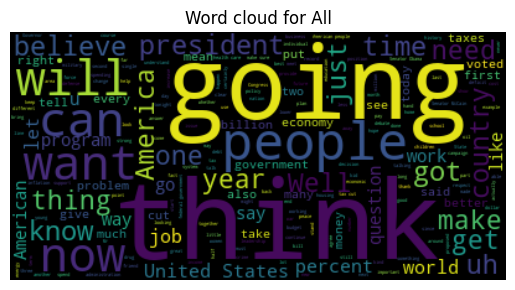

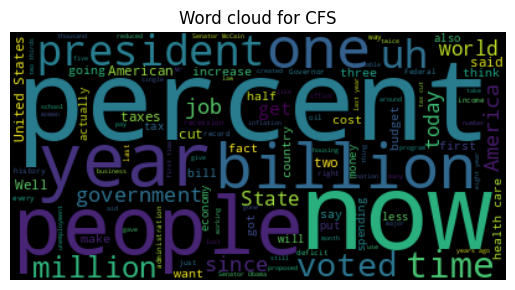

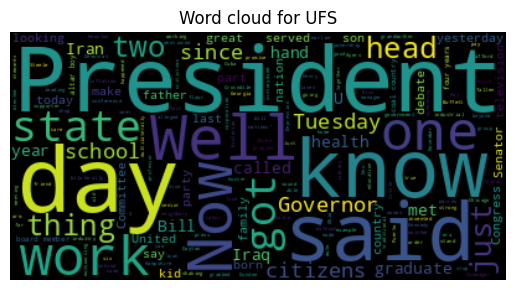

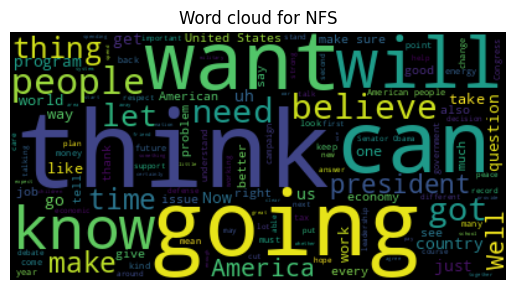

In [2]:
%autoreload

categories = ["All", "CFS", "UFS", "NFS"]
verdicts = [None, ClaimbusterMultiClassLabel.CFS, ClaimbusterMultiClassLabel.UFS, ClaimbusterMultiClassLabel.NFS]
speaker_parties = [f"Word cloud for {category}" for category in categories]
base_dir = os.path.join("..", "figures", "claimbuster", "wordclouds")
file_paths = [os.path.join(base_dir, f"{category}.png") for category in categories] 

if not os.path.exists(base_dir):
    os.makedirs(base_dir)
    
for verdict, speaker_party, file_path in zip(verdicts, speaker_parties, file_paths):
    if verdict is None:
        text = dataframe_to_text(data, labels=["Text"])
    else:
        filtered_data = data[data["Verdict"] == verdict.value]
        text = dataframe_to_text(filtered_data, labels=["Text"])
    show_word_cloud(text, speaker_party, file_path)



## Verdict distribution 

Looking at the distribution of the different verdicts CFS, UFS, and NFS, both the total counts and when grouping by spreaker title and speaker party

### Total distribution

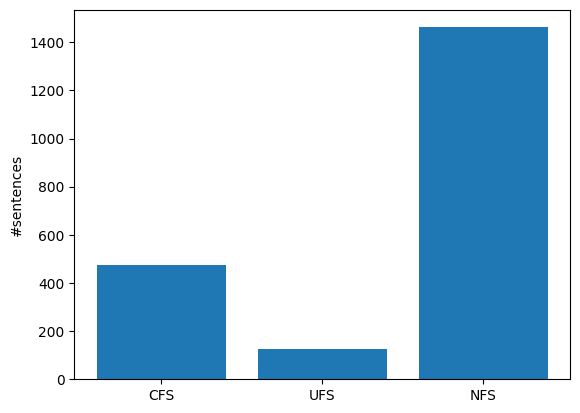

In [3]:
%autoreload

verdicts = [ClaimbusterMultiClassLabel.CFS, ClaimbusterMultiClassLabel.UFS, ClaimbusterMultiClassLabel.NFS]
x = ["CFS", "UFS", "NFS"]
y = [data[data["Verdict"] == verdict.value].shape[0] for verdict in verdicts]
speaker_party = "Total distribution of verdicts"
file_path = os.path.join("..", "figures", "claimbuster", "verdict_distribution", "total_distribution.png")

if not os.path.exists(os.path.dirname(file_path)):
    os.makedirs(os.path.dirname(file_path))

show_histogram_plot(x=x, y=y, ylabel="#sentences", file_path=file_path)

### Verdicts per speaker party

Looking at the verdict distributions for the different party affiliations:
- Republican
- Democrat
- Independent

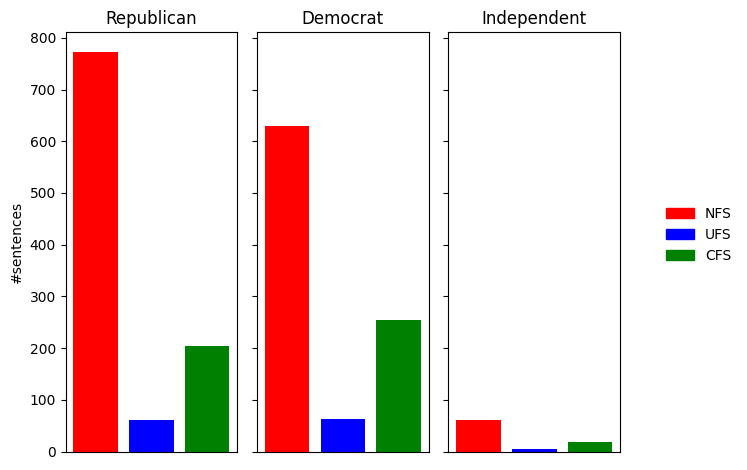

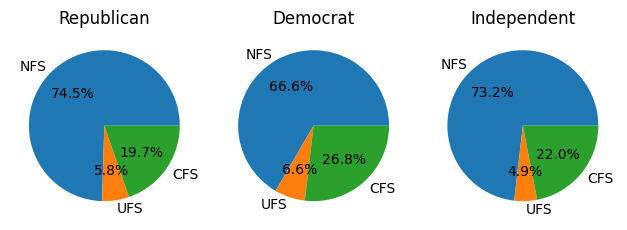

In [4]:
%autoreload

speaker_parties = [
    ClaimbusterSpeakerParty.REPUBLICAN.value,
    ClaimbusterSpeakerParty.DEMOCRAT.value,
    ClaimbusterSpeakerParty.INDEPENDENT.value,
]
titles = ["Republican", "Democrat", "Independent"]
legends = ["NFS", "UFS", "CFS"]
ylabel = "#sentences"
values = []
for speaker_party in speaker_parties:
    verdict_counts = data[data["Speaker_party"] == speaker_party].groupby("Verdict", sort=True).size().to_list()
    values += verdict_counts
bar_plot_file_path = os.path.join("..", "figures", "claimbuster", "verdict_distribution", "speaker_party_bar_plot.png")
if not os.path.exists(os.path.dirname(bar_plot_file_path)):
    os.makedirs(os.path.dirname(bar_plot_file_path))
show_sub_plots_with_legends(
    values=values,
    group_size=3, 
    titles=titles, 
    legends=legends, 
    ylabel=ylabel, 
    colors=["red", "blue", "green"],
    file_path=bar_plot_file_path
)

pie_chart_file_path = os.path.join("..", "figures", "claimbuster", "verdict_distribution", "speaker_party_pie_chart.png")
show_sub_plots_pie_chart(values=values, group_size=3, titles=titles, labels=legends, file_path=pie_chart_file_path)

### Verdicts per speaker title
Looking at the verdict distributions for the different speaker titles:
- Governor
- President
- Senator
- Other (merging Congressman, Former Vice President, Independent Candidate and Vice president categories)

Speaker_title
Congressman               18
Former Vice President     56
Governor                 502
Independent Candidate     64
President                378
Senator                  788
Vice President           258
dtype: int64
[338, 48, 116]
[226, 22, 130]
[584, 36, 168]
{'Independent Candidate', 'Vice President', 'Former Vice President', 'Congressman'}
[314, 20, 62]


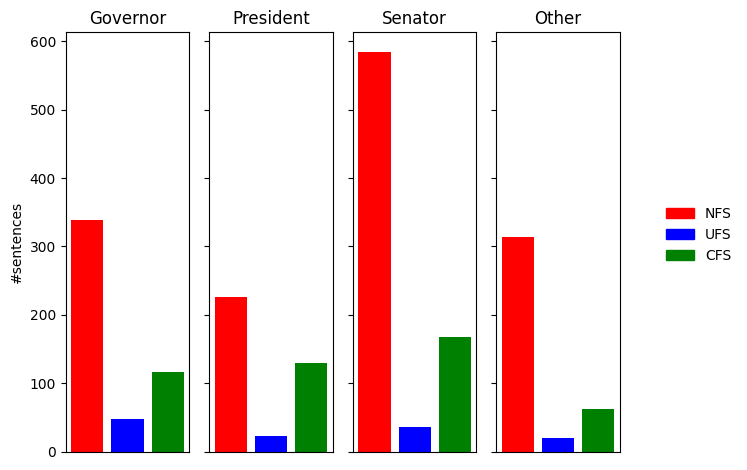

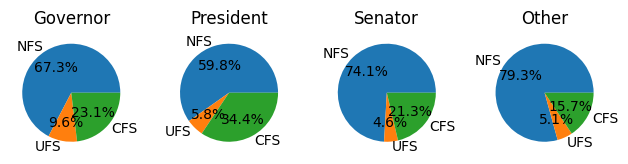

In [5]:
%autoreload

print(data.groupby("Speaker_title").size())
speaker_titles = [
    ClaimBusterSpeakerTitle.GOVERNOR.value,
    ClaimBusterSpeakerTitle.PRESIDENT.value,
    ClaimBusterSpeakerTitle.SENATOR.value,
]
titles = ["Governor", "President", "Senator", "Other"]
legends = ["NFS", "UFS", "CFS"]
values = []
for speaker_title in [*speaker_titles, "Other"]:
    if speaker_title == "Other":
        other_titles = set([item.value for item in ClaimBusterSpeakerTitle]) - set(speaker_titles)
        verdict_counts = data[data["Speaker_title"].isin(other_titles)].groupby("Verdict", sort=True).size().to_list()
    else:
        verdict_counts = data[data["Speaker_title"] == speaker_title].groupby("Verdict", sort=True).size().to_list()
    values += verdict_counts
bar_plot_file_path = os.path.join("..", "figures", "claimbuster", "verdict_distribution", "speaker_title_bar_plot.png")
if not os.path.exists(os.path.dirname(bar_plot_file_path)):
    os.makedirs(os.path.dirname(bar_plot_file_path))
show_sub_plots_with_legends(
    values=values,
    group_size=3, 
    titles=titles, 
    legends=legends, 
    ylabel=ylabel, 
    colors=["red", "blue", "green", "orange"],
    file_path=bar_plot_file_path
)
pie_chart_file_path = os.path.join("..", "figures", "claimbuster", "verdict_distribution", "speaker_title_pie_chart.png")
show_sub_plots_pie_chart(values=values, group_size=3, titles=titles, labels=legends, file_path=pie_chart_file_path)